## **MA5606 Tópicos Matemáticos en Aprendizaje de Máquinas, Redes Neuronales y Aprendizaje Profundo**

### **Tarea 3: Regímenes Sobreparametrizados de Redes Neuronales**

**Profesores: Claudio Muñoz y Joaquín Fontbona**

**Auxiliares: Javier Maass y Diego Olguín**

**Nombres integrantes: COMPLETAR**



**Instrucciones:**

- **Fecha de entrega:** **TBD de 2024, a las 23:59.**

- **Importante:** Si trabaja desde el link de Google Colab debe hacer un copia en su Drive antes de trabajar, de lo contrario se podrían no guardar sus códigos.

- Debe entregar un Jupyter Notebook (archivo .ipynb) con sus código en Python. Le pueden ser de mucha utilidad los códigos vistos en la actividad práctica.

- Sus códigos deben estar comentados y ordenados. Además, en formato texto debe colocar todas sus conclusiones y resultados pedidos que deban ser redactados.

- En todos los ejercicios se le pide hacer al menos un gráfico. Los gráficos que realicen deben ser claros, con títulos y nombres en los ejes, junto con leyendas si es que corresponde.

### **Ejercicio 1: Regímenes Sobreparametrizados de Redes Neuronales**

En esta última parte del curso, hemos estudiado algunos de los regímenes "sobreparametrizados" de redes neuronales que son más comunes en la literatura. En particular, han aparecido los conceptos de [Random Features (RF)](https://papers.nips.cc/paper_files/paper/2007/hash/013a006f03dbc5392effeb8f18fda755-Abstract.html), [Neural Tangent Kernel (NTK)](https://arxiv.org/abs/1806.07572) y el régimen [Mean Field (MF)](https://arxiv.org/abs/1902.06015). Pueden ver también una buena referencia de todos en [esta review](https://arxiv.org/abs/2012.13982).

En este ejercicio buscaremos ilustrar cómo se pueden observar estos regímenes en la práctica, y así también algunos fenómenos interesantes al respecto.

En la tarea anterior ya vimos cómo implementar una red neuronal "desde cero" utilizando numpy y autograd. En este caso, usaremos uno de los frameworks más conocidos y ampliamente utilizados para la implementación de Modelos de Redes Neuronales: pytorch (instalada por defecto en Google Colab).

Importemos las librerías correspondientes:

In [174]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Fijamos una random seed para hacer los experimentos reproducibles
torch.manual_seed(42)
np.random.seed(42)

# Si lo desean, pueden "acelerar" la velocidad de entrenamiento de sus redes neuronales
# al utilizar la GPU de sus computadores (o cambiando el Runtime Type en Colab a uno con GPU)
# Si esto les presenta errores extraños ligados a "CUDA", les recomiendo settear esta variable
# como "cpu" (el todo el notebook corre sin necesidad de usar GPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

En torch trabajaremos con **tensores** en vez de arrays de NumPy. La ventaja es que estos pueden ser procesados en GPUs, lo que permite realizar cálculos mucho más rápido. Por otra parte, torch permite calcular automáticamente los gradientes de funciones que involucran tensores, a través de una implementación interna del módulo autograd. En particular, los tensores tienen un atributo **requires_grad** que determina si estos deben ser "trackeados" como variables con respecto a las cuales se puede derivar.

Como ejemplo, consideremos la derivada de la función $f:\mathbb{R}^{2\times 2} \to \mathbb{R}$ dada por $f(x) = \sum_{i=1}^2 \sum_{j=1}^2 3(x_{i,j}+2)^2$ en el punto $x_0$ dado por la matriz de unos:

In [175]:
x0 = torch.ones(2, 2, requires_grad=True)
z = 3*((x0+2)**2)
out = z.sum()
print('Valor de la funcion en x_0: ', out)
out.backward()
print('Valor del gradiente en x_0: ', x0.grad)

Valor de la funcion en x_0:  tensor(108., grad_fn=<SumBackward0>)
Valor del gradiente en x_0:  tensor([[18., 18.],
        [18., 18.]])


Consideraremos nuevamente una red neuronal de 1 capa oculta de $\mathbb{R}$ en $\mathbb{R}$, con $N$ unidades ocultas. Esto puede describirse como:

$$ \Phi_\theta (x) = W_2 \cdot \sigma (W_1^T \cdot x + b_1) + b_2$$

Con un vector de parámetros $\theta = (W_1, b_1, W_2, b_2)^T \in \mathbb{R}^{3N + 1}$, donde $W_1 \in \mathbb{R}^{1 \times N}$, $b_1 \in \mathbb{R}^{N}$, $W_2 \in \mathbb{R}^{1 \times N}$, $b_2 \in \mathbb{R}$. Sin pérdida de generalidad, podemos escribirlo en la siguiente forma:
$$ \Phi_\theta (x) = \frac{\alpha}{N} \sum_{k=1}^N W_2^{(k)} \cdot \sigma ((W_1^{(k)})^T \cdot x + b_1^{(k)})$$
donde explicitamos la multiplicación de las matrices involucradas, descomponiendo $W_1$, $W_2$ y $b_1$ en sus $N$ componentes (sabiendo que nuestra función de activación actúa puntualmente), y quitando $b_2$ (sabiendo que un componente 'constante' se puede lograr e.g. con $W_1=0$). Por otra parte, el $\frac{\alpha}{N}$ lo 'absorbe' el parámetro lineal en la salida.

Esta escritura nos permitirá entender la red neuronal como un **sistema de $N$ particulas**, definidas por parámetros $\theta_k = (W_1^{(k)}, b_1^{(k)}, W_2^{(k)}) \in \mathbb{R}^3$ con $k = 1, \dots, N$.

Consideraremos $\sigma(x) = \text{sigmoid}(x)$ (aunque siéntanse libres de probar con distintas posibilidades):

In [176]:
activation_fn = torch.sigmoid

Para definir modelos de redes neuronales en torch, se utiliza el submódulo **torch.nn** y, más específicamente, la clase **nn.Module**. Para definir una red neuronal, se debe heredar de nn.Module. Cada capa de la red se define en el método __init__ (usando en general módulos predefinidos de Pytorch, como nn.Linear, nn.Conv2d, etc.). Por su parte, la forma en que la red opera con el "input" se define dentro del método **forward**. Hacerlo de esta forma permite a torch guardar en GPU los parametros de la red y hacer que el procesamiento del input sea lo más rápido posible.

En este caso, definiremos modelos para nuestros 3 regímenes sobreparametrizados de interés (nótese que incluimos un método **init_params** para asegurar que inicializamos las redes con parametros gaussianos, también incluimos un método **get_particles** para obtener las N 'partículas' que definen la red neuronal, es decir, $\theta = (\theta_k)_{k=1}^N \in \mathbb{R}^{N \times 3}$):

- Comenzamos definiendo el modelo de NN para el régimen de Random Features. Nótese que debemos fijar los parámetros de la primera capa, para lo cual empleamos el parámetro requires_grad. Nótese también que el factor de escala en este modelo es $\frac{1}{N}$ (i.e. $\alpha = 1$), como se ha visto en clases.

In [177]:
class RandomFeaturesModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, activation_fn):
        super(RandomFeaturesModel, self).__init__()
        # Nótese que N = hidden_dim.
        # En el caso de Random Features, nuestro parámetro de escala es 1/N
        self.scale = 1/hidden_dim
        # Utilizamos las "capas lineales" que vienen implementadas en torch.
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, 1, bias=False)
        # También definimos la función de activación a utilizar
        self.activation_fn = activation_fn

        # Inicializamos los parámetros de la red.
        self.init_params(input_dim, hidden_dim)

        # Para fijar los parámetros de la primera capa oculta (y que no se entrenen),
        # debemos fijar requires_grad = False
        for param in self.hidden_layer.parameters():
            param.requires_grad = False

    def forward(self, x):
        # En esta función se define el procesamiento de la red.
        x = self.activation_fn(self.hidden_layer(x))

        # Debemos multiplicar por el factor de escala!!
        return self.scale*self.output_layer(x)

    def init_params(self, input_dim, hidden_dim):
        nn.init.normal_(self.hidden_layer.weight, mean=0.0, std=np.sqrt(2/input_dim))
        nn.init.normal_(self.output_layer.weight, mean=0.0, std=np.sqrt(2/(hidden_dim*self.scale)))

    def get_particles(self):
        return torch.stack([self.hidden_layer.weight.clone().squeeze(), self.hidden_layer.bias.clone(), self.output_layer.weight.clone().squeeze()], axis = 1)

**Ejercicio 1.1: Basado en la forma de construir el modelo de RF, defina un módulo "MeanFieldModel", y uno "NTKModel"; que correspondan a los regímenes MF y NTK vistos en clases. Para esto, recuerde que ambos modelos tienen TODOS los parámetros entrenables; la diferencia es que el modelo de NTK tiene un "scaling" distinto, que es de $\frac{1}{\sqrt{N}}$ (i.e. $\alpha = \sqrt{N}$), en vez del $\frac{1}{N}$ (i.e. $\alpha =1$) utilizado por RF y MF.**

**Repuesta:**

In [178]:
class MeanFieldModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, activation_fn):
        super(MeanFieldModel, self).__init__()

        self.scale = 1/hidden_dim # Mismo factor de escala que RF.
        self.hidden_layer = nn.Linear(input_dim, hidden_dim, bias=False)
        self.output_layer = nn.Linear(hidden_dim, 1, bias=False) # Sin bias ahora, pues es Mean Field.
        self.activation_fn = activation_fn
        self.init_params(input_dim, hidden_dim) # En Mean Field, todos los parámetros son entrenables, luego no es necesario fijar requires_grad = False.

    def forward(self, x): # Igual que en RF.
        x = self.activation_fn(self.hidden_layer(x))
        return self.scale*self.output_layer(x)

    def init_params(self, input_dim, hidden_dim):
        nn.init.normal_(self.hidden_layer.weight, mean=0.0, std=np.sqrt(2/input_dim))
        nn.init.normal_(self.output_layer.weight, mean=0.0, std=np.sqrt(2/(hidden_dim*self.scale))) # Igual que en RF.
        return

    def get_particles(self):
        return torch.stack([self.hidden_layer.weight.clone().squeeze(), self.output_layer.weight.clone().squeeze()], axis = 1)

In [179]:
class NTKModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, activation_fn):
        super(NTKModel, self).__init__()

        self.scale = 1/np.sqrt(hidden_dim)
        self.hidden_layer = nn.Linear(input_dim, hidden_dim, bias=False)
        self.output_layer = nn.Linear(hidden_dim, 1, bias=False) # Sin bias ahora, pues es NTK.
        self.activation_fn = activation_fn
        self.init_params(input_dim, hidden_dim) # En NTK, todos los parámetros son entrenables, luego no es necesario fijar requires_grad = False.

    def forward(self, x): # Igual que en RF.
        x = self.activation_fn(self.hidden_layer(x))
        return self.scale*self.output_layer(x)

    def init_params(self, input_dim, hidden_dim):
        nn.init.normal_(self.hidden_layer.weight, mean=0.0, std=np.sqrt(2/input_dim))
        nn.init.normal_(self.output_layer.weight, mean=0.0, std=np.sqrt(2/(hidden_dim*self.scale))) # Igual que en RF.
        return

    def get_particles(self):
        return torch.stack([self.hidden_layer.weight.clone().squeeze(), self.output_layer.weight.clone().squeeze()], axis = 1)

#### Un problema sencillo
En este Ejercicio consideraremos un problema "de juguete", en que queremos que nuestros modelos aproximen la función $f(x) = \sin(\pi x)$ a partir de observaciones ruidosas. Para esto, consideremos el siguiente método que nos permite generar datos sintéticos para este problema.

In [180]:
# Nótese que nuestro dataset está compuesto por tensores de torch.
def generate_data(n_samples=100, noise=0.1):
    X = np.linspace(-1, 1, n_samples).reshape(-1, 1)
    y = np.sin(np.pi * X) + noise * np.random.randn(n_samples, 1)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

Por otro lado, consideren la siguiente función que les permitirá graficar los datos, así como, eventualmente, las predicciones de sus modelos.

In [181]:
def plot_data_predictions(X_train, y_train, X_test, y_test,
                     rf_predictions=None,
                     ntk_predictions=None,
                     mf_predictions=None):
  plt.scatter(X_train, y_train, label='Train data', color = "grey", alpha=0.1)
  plt.scatter(X_test, y_test, label='Test data', color = "black", alpha=0.5)
  plt.plot(X_test, np.sin(np.pi * X_test), label='True function', color='black')
  if rf_predictions is not None:
    plt.plot(X_test, rf_predictions, label='Random Features', linestyle='dashed')
  if ntk_predictions is not None:
    plt.plot(X_test, ntk_predictions, label='Neural Tangent Kernel', linestyle='dotted')
  if mf_predictions is not None:
    plt.plot(X_test, mf_predictions, label='Mean Field Limit', linestyle='dashdot')
  plt.legend()
  plt.show()

Generemos y Visualicemos los datos:

In [182]:
X_train, y_train = generate_data(n_samples = 200, noise = 0.3)
X_test, y_test = generate_data(n_samples=40, noise = 0.15)

Forma de los tensores involucrados:
X shape:  torch.Size([200, 1]) y shape:  torch.Size([200, 1]) 



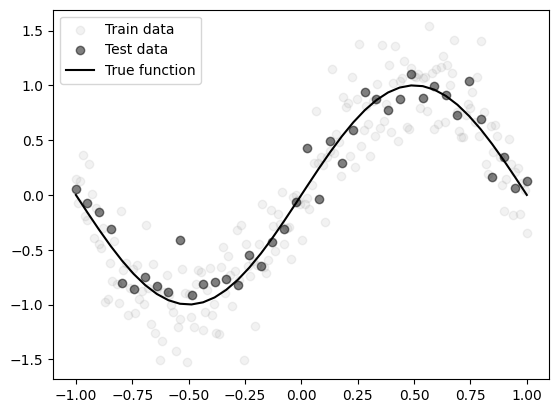

In [183]:
print("Forma de los tensores involucrados:")
print("X shape: ", X_train.shape, "y shape: ", y_train.shape, "\n")
plot_data_predictions(X_train, y_train, X_test, y_test)

#### Framework de Entrenamiento Típico con PyTorch

Para entrenar modelos de NN en torch existen muchas herramientas que nos permiten implementar técnicas más avanzadas de entrenamiento, que les serán muy útiles si quieren trabajar con este tipo de modelos en la práctica (pueden ver [este link](https://pytorch.org/docs/stable/data.html), [este](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) y [este](https://pytorch.org/vision/main/transforms.html) para más información).

En particular, los **Dataset** de Pytorch son una forma "fancy" de empaquetar los datos para que PyTorch pueda entender qué hacer con ellos. Por otro lado, esto nos permite "leer los datos en tiempo real", sin necesidad de tenerlos todos cargados en memoria constantemente (lo cual es muy útil cuando hay que trabajar con grandes conjuntos de datos que no caben en la RAM).

En nuestro caso, para este problema simple, **TensorDataset** (que es un Dataset que viene por defecto con torch) es más que suficiente empaquetar nuestros pares (dato, etiqueta).

Por otro lado, se emplean los **DataLoader** de PyTorch para iterar sobre los datos de forma "eficiente", permitiendo el uso de mini-batches, shuffling y paralelización.

In [184]:
from torch.utils.data import DataLoader, TensorDataset

# Creamos los TensorDataset y los DataLoader de PyTorch
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)#, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)#, num_workers=2)

Con esto listo, un loop de Entrenamiento-Evaluación típico de torch es el siguiente (nótese que incluimos dentro del loop una funcionalidad para retornar las partículas en cada paso del entrenamiento):

In [185]:
# Loop de Entrenamiento-Evaluacion para cualquiera de nuestros modelos.
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=1000, return_particles = True, has_get_particles = True):
    model = model.to(device)
    train_losses = []
    param_changes = []

    initial_particles = model.get_particles() if has_get_particles else None
    particles = [initial_particles]

    #Entrenamiento
    for epoch in tqdm(range(epochs)):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch.to(device))
            loss = criterion(outputs, y_batch.to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))
        if has_get_particles:
          current_particles = model.get_particles()
          if return_particles:
            particles.append(current_particles)
          param_change = torch.sqrt(((initial_particles - current_particles)**2).sum(axis=1)).mean()
          param_changes.append(param_change.detach().cpu().numpy())
          initial_particles = current_particles

    # Evaluación
    model.eval()
    test_loss = 0
    all_predictions = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch.to(device))
            loss = criterion(predictions, y_batch.to(device))
            test_loss += loss.item()
            all_predictions.append(predictions)
        test_loss /= len(test_loader)
        all_predictions = torch.cat(all_predictions).cpu().numpy()

    return all_predictions, test_loss, train_losses, param_changes, particles

#### Entrenamiento de Modelos para este problema

En el caso de nuestras redes **sobreparametrizadas**, nos interesará ver qué pasa para diferentes valores de $N$. También, dependiendo del régimen considerado, la teoría vista en el curso es aplicable en la medida que la cantidad de épocas que se ocupen sea suficiente (e.g. el Régimen MF requiere de un entrenamiento con $N\cdot T$ épocas para estar en el scaling 'correcto') o que las constantes tengan valores razonables (e.g. el régimen de NTK requiere un learning rate 'pequeño' para que la "linealización" de la acción de la red tenga sentido). Definamos, ante todo, los hiperparámetros globales del entrenamiento:

In [186]:
input_dim = 1
LRs = (0.5, 0.01, 1)
WDs = (0, 0, 0)

N = 1000
T = 1

criterion = nn.MSELoss()
EPOCHS = (int(N*T), int(np.sqrt(N)*T), int(N*T))

Entrenando RF:

In [187]:
rf_model = RandomFeaturesModel(input_dim, N, activation_fn)
rf_optimizer = optim.Adam(filter(lambda p: p.requires_grad, rf_model.parameters()), lr=LRs[0], weight_decay=WDs[0])
rf_predictions, rf_loss, rf_train_losses, rf_param_changes, particles_rf = train_and_evaluate(rf_model, train_loader, test_loader, criterion, rf_optimizer, epochs = EPOCHS[0])

100%|██████████| 1000/1000 [00:08<00:00, 119.77it/s]


Entrenando NTK:

In [188]:
ntk_model = NTKModel(input_dim, N, activation_fn)
ntk_optimizer = optim.Adam(filter(lambda p: p.requires_grad, ntk_model.parameters()), lr=LRs[1], weight_decay=WDs[1])
ntk_predictions, ntk_loss, ntk_train_losses, ntk_param_changes, particles_ntk = train_and_evaluate(ntk_model, train_loader, test_loader, criterion, ntk_optimizer, epochs = EPOCHS[1])

100%|██████████| 31/31 [00:00<00:00, 108.95it/s]


Entrenando MF:

In [189]:
mf_model = MeanFieldModel(input_dim, N, activation_fn)
mf_optimizer = optim.Adam(filter(lambda p: p.requires_grad, mf_model.parameters()), lr=LRs[2], weight_decay=WDs[2])
mf_predictions, mf_loss, mf_train_losses, mf_param_changes, particles_mf = train_and_evaluate(mf_model, train_loader, test_loader, criterion, mf_optimizer, epochs = EPOCHS[2])

100%|██████████| 1000/1000 [00:09<00:00, 108.08it/s]


**Ejercicio 1.2: Defina una función train_everything que reciba los hiperparámetros de entrenamiento y retorne, por una parte, un diccionario de llaves 'RF', 'NTK' y 'MF', cuyos valores sean los resultados de un entrenamiento bajo los hiperparámetros definidos; y por otra parte un diccionario con los modelos finales obtenidos**

**Respuesta:**

In [190]:
def train_everything(N = 1000,
                     T = 1,
                     input_dim = 1,
                     LRs = (0.5, 0.001, 1),
                     WDs = (0, 0, 0),
                     criterion = nn.MSELoss(),
                     EPOCHS = (int(1000*1), int(np.sqrt(1000)*1), int(1000*1)),
                     activation_fn = torch.sigmoid,
                     ):
    out = {}
    models = {}

    rf_model = RandomFeaturesModel(input_dim, N, activation_fn)
    rf_optimizer = optim.Adam(filter(lambda p: p.requires_grad, rf_model.parameters()), lr=LRs[0], weight_decay=WDs[0])
    rf_predictions, rf_loss, rf_train_losses, rf_param_changes, particles_rf = train_and_evaluate(rf_model, train_loader, test_loader, criterion, rf_optimizer, epochs = EPOCHS[0])
    out['RF'] = (rf_predictions, rf_loss, rf_train_losses, rf_param_changes, particles_rf)
    models['RF'] = rf_model

    ntk_model = NTKModel(input_dim, N, activation_fn)
    ntk_optimizer = optim.Adam(filter(lambda p: p.requires_grad, ntk_model.parameters()), lr=LRs[1], weight_decay=WDs[1])
    ntk_predictions, ntk_loss, ntk_train_losses, ntk_param_changes, particles_ntk = train_and_evaluate(ntk_model, train_loader, test_loader, criterion, ntk_optimizer, epochs = EPOCHS[1])
    out['NTK'] = (ntk_predictions, ntk_loss, ntk_train_losses, ntk_param_changes, particles_ntk)
    models['NTK'] = ntk_model

    mf_model = MeanFieldModel(input_dim, N, activation_fn)
    mf_optimizer = optim.Adam(filter(lambda p: p.requires_grad, mf_model.parameters()), lr=LRs[2], weight_decay=WDs[2])
    mf_predictions, mf_loss, mf_train_losses, mf_param_changes, particles_mf = train_and_evaluate(mf_model, train_loader, test_loader, criterion, mf_optimizer, epochs = EPOCHS[2])
    out['MF'] = (mf_predictions, mf_loss, mf_train_losses, mf_param_changes, particles_mf)
    models['MF'] = mf_model    

    return out, models

Utilicemos nuestra función train_everything para probar diferentes configuraciones y ver qué pasa:

In [191]:
out, models = train_everything(N = N, T = T, input_dim = input_dim, LRs = LRs, WDs = WDs, criterion = criterion, EPOCHS = EPOCHS, activation_fn = activation_fn)

100%|██████████| 1000/1000 [00:09<00:00, 101.73it/s]


In [192]:
rf_predictions, rf_loss, rf_train_losses, rf_param_changes, particles_rf = out["RF"]
ntk_predictions, ntk_loss, ntk_train_losses, ntk_param_changes, particles_ntk = out["NTK"]
mf_predictions, mf_loss, mf_train_losses, mf_param_changes, particles_mf = out["MF"]

Podemos entender cuál de los modelos obtuvo la mejor pérdida sobre el conjunto de test para los hiperparámetros definidos:

In [193]:
# Print test losses
print(f'Random Features Test Loss: {rf_loss:.4f}')
print(f'Neural Tangent Kernel Test Loss: {ntk_loss:.4f}')
print(f'Mean Field Limit Test Loss: {mf_loss:.4f}')

Random Features Test Loss: 0.0352
Neural Tangent Kernel Test Loss: 0.1610
Mean Field Limit Test Loss: 0.1026


Asimismo, utilizamos la función plot_data_predictions para visualizar los resultados obtenidos.

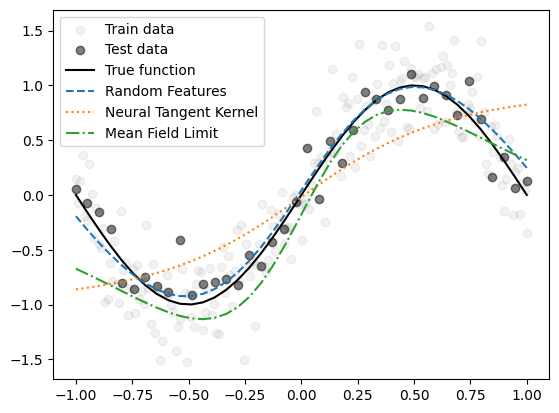

In [194]:
plot_data_predictions(X_train, y_train, X_test, y_test, rf_predictions, ntk_predictions, mf_predictions)

**Ejercicio 1.3: Describa los resultados obtenidos**

**Respuesta:**


#### Entendiendo el Entrenamiento bajo los diferentes regímenes sobreparametrizados

Las siguientes funciones nos permitirán entender cómo evolucionaron las losses a lo largo del entrenamiento, y así también qué tanto cambian los parámetros de la red a lo largo del entrenamiento. Nótese que, para ver los distintos regímenes de entrenamiento en escalas comparables, estamos "reescalando los vectores de losses" para ponerlos todos en una misma escala temporal.

In [195]:
# Función para visualizar el comportamiento de las redes durante el entrenamiento
def plot_training_metrics(train_losses_list, param_changes_list, labels, scales = EPOCHS, T = 1):
    plt.figure(figsize=(14, 6))

    # Graficamos la evolución de la loss
    plt.subplot(1, 2, 1)
    for j, (train_losses, label) in enumerate(zip(train_losses_list, labels)):
        ws = max(int(scales[j]/T), 1)
        series = torch.nn.functional.avg_pool1d(torch.tensor(train_losses).unsqueeze(0).unsqueeze(1), kernel_size=ws, stride=ws).squeeze()
        plt.plot(series, label=label)
    plt.xlabel('Abstract Time')
    plt.ylabel('Training Loss')
    plt.yscale("log")
    plt.legend()
    plt.title('Training Losses')

    # Graficamos los "cambios" en los parámetros
    plt.subplot(1, 2, 2)
    for j, (param_changes, label) in enumerate(zip(param_changes_list, labels)):
        ws = max(int(scales[j]/T),1)
        series = torch.nn.functional.avg_pool1d(torch.tensor(np.stack(param_changes)).unsqueeze(0).unsqueeze(1), kernel_size=ws, stride=ws).squeeze()
        plt.plot(series, label=label)

    plt.xlabel('Abstract Time')
    plt.ylabel('Parameter Variation')
    plt.yscale("log")
    plt.legend()
    plt.title('Parameter Variations')

    plt.tight_layout()
    plt.show()

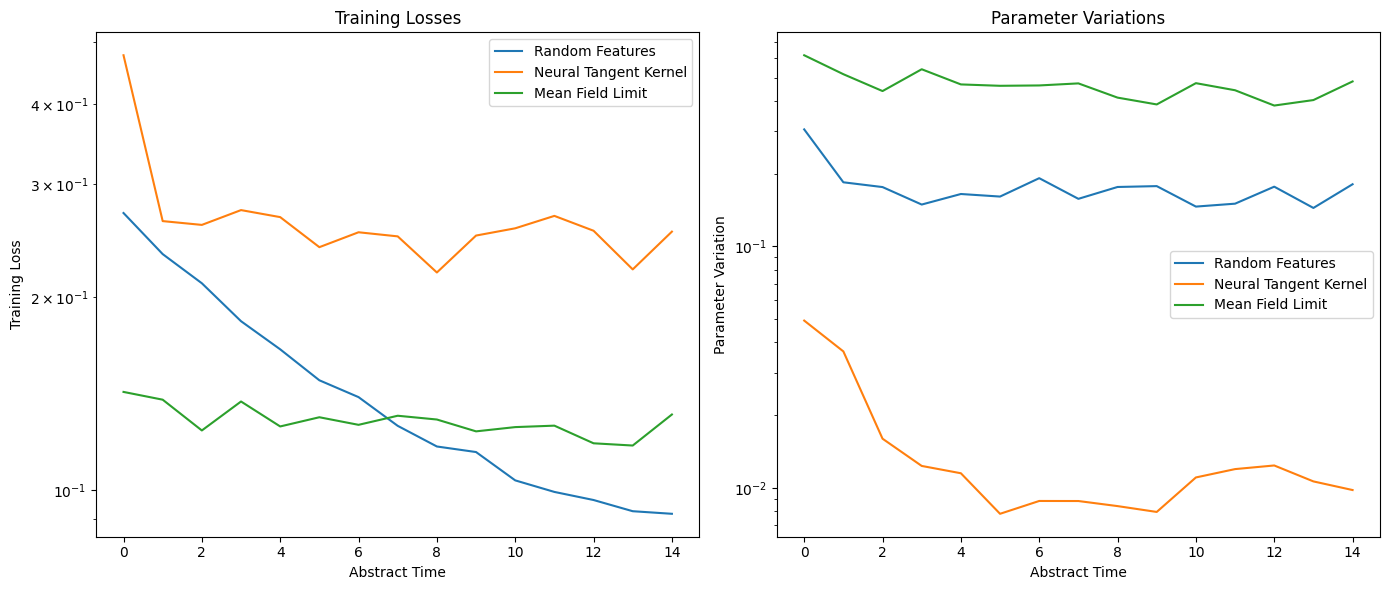

In [196]:
labels = ["Random Features", "Neural Tangent Kernel", "Mean Field Limit"]
plot_training_metrics([rf_train_losses, ntk_train_losses, mf_train_losses],
                      [rf_param_changes, ntk_param_changes, mf_param_changes],
                      labels, scales = EPOCHS, T = 15*T)

La siguiente función permite realizar una animación de la evolución de las partículas durante el entrenamiento (viéndolas en la escala que corresponda).

In [197]:
import plotly.graph_objects as go

def plot_particles_animation(particle_snapshots, p_size = 5,  lims = (10,10,10), scale = 1, T = 1, method = ""):
    """
    Crea una animación de la posición de los parámetros de la red en un gráfico de parámetros 3D.

    Parámetros:
    particle_snapshots (lista de torch.Tensor): Lista de tensores, cada uno de shape (N, 3),
                                                representando la posicion de los parametros de la red en cada época.
    """
    ws = max(int(scale/T),1)
    particle_snapshots = particle_snapshots[::ws] # 'Vemos' las partículas en la escala correspondiente.
    frames = []
    N = particle_snapshots[0].shape[0]

    for i, particles in enumerate(particle_snapshots):
        x = particles[:, 0].detach().cpu().numpy()
        y = particles[:, 1].detach().cpu().numpy()
        z = particles[:, 2].detach().cpu().numpy()

        frames.append(go.Frame(data=[go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            marker=dict(
                size=p_size,
                color=z,  # El color lo determina el valor de w_2
                colorscale='Viridis',
                opacity=0.8
            )
        )], name=f'frame{i}'))

    x = particle_snapshots[0][:, 0].detach().cpu().numpy()
    y = particle_snapshots[0][:, 1].detach().cpu().numpy()
    z = particle_snapshots[0][:, 2].detach().cpu().numpy()

    # Se ocupan muchos tecnicismos propios de plotly, no es necesario que entiendan este código.
    fig = go.Figure(
        data=[go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            marker=dict(
                size=p_size,
                color=z,
                colorscale='Viridis',
                opacity=0.8
            )
        )],
        layout=go.Layout(
            title=f'Animacion de la Evolución de la NN durante el Entrenamiento <br><sup>Método: {method}</sup>',
            scene=dict(
                xaxis_title='w1',
                yaxis_title='b1',
                zaxis_title='w2',
                xaxis_range=[-lims[0],lims[0]],
                yaxis_range=[-lims[1],lims[1]],
                zaxis_range=[-lims[2],lims[2]],
                aspectmode ='cube',
            ),
            updatemenus=[{
                'buttons': [
                    {
                        'args': [None, {'frame': {'duration': 100, 'redraw': True}, 'fromcurrent': True}],
                        'label': 'Play',
                        'method': 'animate'
                    },
                    {
                        'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                        'label': 'Pause',
                        'method': 'animate'
                    }
                ],
                'direction': 'left',
                'pad': {'r': 10, 't': 87},
                'showactive': False,
                'type': 'buttons',
                'x': 0.1,
                'xanchor': 'right',
                'y': 0,
                'yanchor': 'top'
            }],
            sliders=[{
                'steps': [{
                    'args': [[f'frame{k}'], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                    'label': str(k),
                    'method': 'animate'
                } for k in range(len(particle_snapshots))],
                'active': 0,
                'yanchor': 'top',
                'xanchor': 'left',
                'currentvalue': {
                    'font': {'size': 20},
                    'prefix': 'Frame:',
                    'visible': True,
                    'xanchor': 'right'
                },
                'transition': {'duration': 0},
                'pad': {'b': 10, 't': 50},
                'len': 0.9,
                'x': 0.1,
                'y': 0
            }]
        ),
        frames=frames
    )

    fig.show()


In [198]:
plot_particles_animation(particles_rf, p_size=2, lims = (6,1,150), scale = EPOCHS[0], T= 15*T, method="Random Features")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
plot_particles_animation(particles_ntk, p_size = 2, lims = (10,7,1), scale = EPOCHS[1], T= 15*T, method = "Neural Tangent Kernel")

In [ ]:
plot_particles_animation(particles_mf, p_size = 2, lims = (200,200,200), scale = EPOCHS[2], T= 15*T, method="Mean Field")

**Ejercicio 1.4: Haga un breve análisis de lo que se observa durante el entrenamiento a nivel de pérdidas, variación de parámetros y la posición de las partículas para cada método (en particular, enfatice lo que diferencia a cada uno de los regímenes). Ve algún fenómeno de "lazy-training" bajo alguno de los regímenes?**

**Respuesta:**

#### Búsqueda de Hiperparámetros

**Ejercicio 1.5: Repita los experimentos anteriores para 3 configuraciones distintas de parámetros (e.g. variando los LRs, considerando WDs >0, cambiando el método de optimización (pueden ver [aquí](https://pytorch.org/docs/stable/optim.html) algunos algoritmos de referencia), cambiando la función de pérdida (pueden ver [aquí](https://pytorch.org/docs/stable/nn.html#loss-functions) algunas de referencia), variando T; etc.). Tras esto, defina una buena configuración de hiperparámetros, la cual utilizaremos en la siguiente pregunta.**

**Respuesta:**

In [ ]:
# Rellene con su código aquí

#### Estudio de la importancia de $N\to\infty$

**Ejercicio 1.6: Queremos visualizar el comportamiento de las redes con $N\to \infty$. Para esto, fije un valor de $T$ que le parezca conveniente, y entrene redes con RF, NTK y MF, para $N=[5, 10, 50, 100, 500, 1000, 5000]$ (recuerde que la cantidad de "épocas de entrenamiento" depende de este valor de $N$). Repita cada experimento al menos $N_{reps} = 5$ veces. Con esta información, grafique la test_loss obtenida para los diferentes regímenes y para los distintos valores de $N$ (incluyendo barras de error). Le puede ser muy útil la función train_everything definida anteriormente.**

Para esto, le será útil la siguiente función para graficar:

In [ ]:
def plot_losses_with_error_bars(N_values, rf_losses, ntk_losses, mf_losses):
    """
    Input:
        N_values: Lista de valores de N utilizados en los experimentos.
        rf_losses: Diccionario de losses para Random Features.
        ntk_losses: Diccionario de losses para Neural Tangent Kernel.
        mf_losses: Diccionario de losses para Mean Field.
        Estos diccionarios de losses deben ser de la forma: {N: [lista_de_losses]}
        i.e. las llaves son los distintos valores de N empleados, y el objeto
        asociado es una lista con las losses correspondientes a cada una de las
        repeticiones del experimento.
    """
    rf_means = [np.mean(rf_losses[N]) for N in N_values]
    rf_stds = [np.std(rf_losses[N]) for N in N_values]

    ntk_means = [np.mean(ntk_losses[N]) for N in N_values]
    ntk_stds = [np.std(ntk_losses[N]) for N in N_values]

    mf_means = [np.mean(mf_losses[N]) for N in N_values]
    mf_stds = [np.std(mf_losses[N]) for N in N_values]

    plt.figure(figsize=(10, 6))

    plt.errorbar(N_values, rf_means, yerr=rf_stds, label='Random Features', marker='o', capsize=5)
    plt.errorbar(N_values, ntk_means, yerr=ntk_stds, label='Neural Tangent Kernel', marker='o', capsize=5)
    plt.errorbar(N_values, mf_means, yerr=mf_stds, label='Mean Field', marker='o', capsize=5)

    plt.xlabel('N')
    plt.ylabel('Test Loss')
    plt.xscale("log")
    plt.title('Test Loss vs. N for Different Models with Error Bars')
    plt.legend()
    plt.grid(True)
    plt.show()

**Respuesta:**

In [ ]:
# Rellene con su código aquí

In [ ]:
# Rellene con su código para graficar con barras de error.
plot_losses_with_error_bars(N_values, rf_losses, ntk_losses, mf_losses)

**Ejercicio 1.7: Describa los resultados obtenidos, y explíquelos desde la perspectiva de los conceptos estudiados en el curso (e.g. sobreparametrización, overfitting, aproximación universal, etc.)**

**Respuesta:**

### **Ejercicio 2: Aplicación de ideas de _sobreparametrización_ en un problema "real"**

En esta sección implementaremos un método de clasificación de series de tiempo (llamado MiniRocket, véase este [link](https://arxiv.org/abs/2012.08791)) para intentar resolver un problema "real". Para esto, utilizaremos una implementación del método MiniRocket de la librería sktime.

In [ ]:
!pip install sktime

El algoritmo de MiniRocket es una variante más ligera y eficiente del algoritmo ROCKET (ver este [link](https://arxiv.org/abs/1910.13051)), el cual guarda muchísimas similitudes con el modelo de Random Features (RF) que trabajamos en el ejercicio anterior.

En el modelo de RF que usamos, dado que la primera capa de la red está "fija" (en valores aleatorios para cada peso), la acción de la red es equivalente a "extraer $N$ características aleatorias a partir del dato de entrada" (con la primera capa) y luego clasificarlas utilizando un modelo lineal (con la segunda capa, que es entrenable).

En el caso de MiniRocket, los datos de entrada corresponden a series de tiempo que son, en principio, más complejas. Siguiendo una lógica similar a RF, el método extrae una **gran cantidad de características aleatorias** a partir de la serie de tiempo (en este caso, utilizando _convoluciones aleatorias_ mejor adaptadas a este tipo de dato) y luego las clasifica utilizando un modelo lineal. Para más información pueden ver los papers originales ([ROCKET](https://arxiv.org/abs/1910.13051) y [MiniRocket](https://arxiv.org/abs/2012.08791)).

La idea de este ejercicio será simplemente utilizar estos algoritmos para resolver un problema aplicado. Noten que la metodología que emplearemos es aplicable a todo tipo de problema de clasificación de series de tiempo, y quedan cordialmente invitad@s a intentar utilizarla en los problemas que les aparezcan a futuro.

Importemos las librerías necesarias:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sktime.transformations.panel.rocket import MiniRocket
from sktime.classification.kernel_based import RocketClassifier
from sktime.datasets import load_basic_motions, load_italy_power_demand, load_acsf1, load_UCR_UEA_dataset

#### Un problema "real"

Utilizaremos nuestro brillante algoritmo de clasificación de series de tiempo (TSC) sobre el dataset **SelfRegulationSCP1** de la base de datos abierta de UCR (ver [aquí](https://www.timeseriesclassification.com/index.php) para mayores referencias).

Los datos corresponden a registros de ElectroeEncefaloGrama (EEG) de un sujeto saludable, al que se le pidió mover un cursor arriba y abajo en la pantalla de un computador (mientras se medían sus potenciales corticales).

Al sujeto se le midieron '6 canales' de su señal cerebral (A1-Cz, A2-Cz, 2cm frontal de C3, 2 cm parietal de C3, 2 cm frontal de C4 y 2 cm parietal de C4), en múltiples mediciones de 3.5 segundos, sampleadas a una frecuencia de 256 Hz. Esto se traduce en que tenemos múltiples series de tiempo de "6 canales" (i.e. tiene 6 dimensiones) de largo 896 cada una. Todos los valores están medidos en microVolts.

Cada serie de tiempo está clasificada según el movimiento del cursor que imprimía el sujeto. En particular, la _positividad cortical_ corresponde a un movimiento descendente del cursor, mientras que la negatividad cortical corresponde a uno ascendente.

En total, hay  268 muestras de entrenamiento y 293 muestras de prueba para este problema, a las cuales podemos acceder a través de la funciones integradas de sktime:

In [ ]:
X_train, y_train = load_UCR_UEA_dataset(name="SelfRegulationSCP1", split="train", return_X_y=True, return_type = "numpy3D")
X_test, y_test = load_UCR_UEA_dataset(name="SelfRegulationSCP1", split="test", return_X_y=True, return_type = "numpy3D")

Estos datos vienen estructurados como tensores de orden 3, donde la primera dimensión corresponde a las diferentes muestras ($B$), la segunda al número de canales ($C$) y la tercera al largo de la serie de tiempo ($L$):

In [ ]:
print("Train Data Shape (B, C, L):", X_train.shape)
print("Test Data Shape (B, C, L):", X_test.shape)

Para visualizar estos datos, consideren la siguiente función que samplea aleatoriamente algunas de las muestras de las series de tiempo y las grafica junto con su clase. El gráfico en el eje x tiene el tiempo, en el eje y la intensidad de la señal (en microVolts) y cada uno de los 6 canales de la señal se representa con un color distinto.

In [ ]:
def plot_sample_time_series(X, y, num_samples=3, title="Algunos Ejemplos de las Series de Tiempo"):
    plt.figure(figsize=(8, num_samples*2.4))
    num_channels = len(X[0])
    channel_names = ["A1-Cz", "A2-Cz", "2cmfC3", "2cmpC3", "2cmfC4", "2cmpC4"]
    indices = np.random.choice(range(len(X)),num_samples, replace=False)
    lims = X.max()
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i + 1)
        for ch in range(num_channels):
            plt.plot(X[indices[i]][ch], label=channel_names[ch])
        plt.title(f"Muestra {i+1}, Clase: {y[indices[i]]}")
        plt.xlabel("Tiempo")
        plt.ylabel("Intensidad")
        plt.ylim((-0.8*lims, 0.8*lims))
        if i ==0:
          plt.legend(loc="upper right")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

Vemos algunos ejemplos:

In [ ]:
plot_sample_time_series(X_train, y_train, num_samples = 3)

#### Un modelo de "Random Features"

El módulo de MiniRocket nos permite, a partir de nuestros datos de series de tiempo, obtener una matriz de muchas "features aleatorias" (de la forma $(B,F)$, con $F$ el número de _features_ extraídas). Esto se realiza utilizando una estructura muy similar a los modelos tradicionales de sklearn:

**Ejercicio 2.1: Defina una instancia del modelo de MiniRocket basándose en el framework de sktime (vean este [link](https://www.sktime.net/en/stable/examples/transformation/minirocket.html) para más información), y utilícelo para obtener matrices de características X_train_transform y X_test_transform, a partir de X_train y X_test respectvamente.**

**Respuesta:**

In [ ]:
# Rellene con su código aquí:

# Defina su estimador

# Hagale .fit() con los datos de entrenamiento

# Obtenga X_train_transform y X_test_transform

Obtenemos la forma de la matriz de "features aleatorias":

In [ ]:
print("Train Data Shape (B, F):", X_train_transform.shape)
print("Test Data Shape (B, F):", X_test_transform.shape)

También les damos una función para visualizar aproximadamente las _features_ obtenidas para algunas muestras de datos:

In [ ]:
def plot_transformed_features(X_transform, y, num_samples = 10, title="Ejemplos de las Features Aleatorias obtenidas"):
    plt.figure(figsize=(12, 6))
    indices = np.random.choice(range(len(X_transform)),num_samples, replace=False)
    ax = sns.heatmap(X_transform.loc[indices].T, cmap="viridis", cbar=True)
    ax.set_xticks(np.arange(num_samples) + 0.5)
    ax.set_xticklabels(y[indices], rotation=45, ha="right")
    plt.title(title)
    plt.xlabel("Datos (Clase)")
    plt.ylabel("Features Aleatorias")
    plt.show()

In [ ]:
plot_transformed_features(X_train_transform, y_train, num_samples=20)

#### Clasificación a partir de las RFs


**Ejercicio 2.2: Defina un modelo de lineal de clasificación de sklearn (e.g. [RidgeClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifierCV.html), [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) u otro de su interés). Entrénelo utilizando X_train_transform y evalúelo sobre X_test_transform. Para esto último utilice la siguiente función para visualizar la matriz de confusión obtenida (véase [este link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) para mayor información) y las métricas de clasificación del modelo (generadas utilizando el [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn). Describa las métricas de clasificación obtenidas y utilícelas para definir qué tan bueno (o no) es su modelo.**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_confusion_matrix(y_test, y_pred, class_names, title="Matriz de Confusión"):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()
    print("\n Métricas de Clasificación: \n")
    print(classification_report(y_test, y_pred, target_names=class_names, digits = 4))

**Respuesta:**

In [ ]:
# Rellene con su código aquí

#### Aproximación al problema con NNs y torch

Si bien el problema ya está relativamente "resuelto" con la parte anterior, es interesante también ver cómo se comportaría una red neuronal entrenada sobre nuestros vectores de _features aleatorias_ (parecido a como lo hicimos en la sección anterior).

Los modelos de clasificación de torch necesitan etiquetas numéricas, por lo que utilizamos un LabelEncoder de sklearn para codificar las etiquetas correctamente:

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

**Ejercicio 2.3: Transforme los datos de X_train_transform, X_test_transform, y_train_encoded e y_test_encoded a formato torch.tensor (cuidando que los int no se transformen en float), y cree los TensorDataset y DataLoaders necesarios para entrenar NNs con torch**

**Respuesta:**

In [ ]:
# Rellene con su código aquí:

# Convierta los datos a torch.tensor().
# Defínalos utilizando el parametro dtype correctamente para no tener problemas después.

# Cree los TensorDataset() correspondientes.

# Cree los DataLoaders() correspondientes.

Considere un modelo lineal simple que se entrenará sobre las _features aleatorias_ generadas por MiniRocket:

In [ ]:
input_dim = X_train_transform.shape[1]
num_classes = 2

model = nn.Linear(input_dim, num_classes)

**Ejercicio 2.4: Utilice la misma función train_and_evaluate de la sección anterior (en esta ocasión, considerando has_get_particles = False), para entrenar este modelo. La función de pérdida en los problemas de clasificación suele ser la llamada [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), pero siéntanse libres de explorar otras posibilidades.**

**Respuesta:**

In [ ]:
# Rellene con su código aquí

In [ ]:
# Rellene con su código aquí
# (recuerde utilizar train_and_evaluate con has_get_particles = False)

**Ejercicio 2.5: Grafique la evolución de la training_loss durante el entrenamiento (puede utilizar la siguiente función), y evalúe el modelo obtenido observando la matriz de confusión y las métricas de clasificación obtenidas. Modifique los hiperparámetros considerados para obtener el mejor resultado posible (e.g. pruebe agregar "weights" a la CrossEntropyLoss, cambiar el algoritmo de optimización, modificar la arquitectura de la red empleada, usar un "ensamble" de modelos, etc.). Discuta sus resultados y compárelos con los del modelo de sklearn anterior.**

In [ ]:
def plot_train_loss(train_losses):
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.yscale("log")
    plt.title('Evolución de la Training Loss')
    plt.show()

Note que el modelo predice la "probabilidad" de que un dato pertenezca a cada clase determinada. Para obtener las clases predichas por el modelo, debemos acceder al argmax de dicha probabilidad (i.e. la clase de máxima probabilidad).

In [ ]:
y_pred_NN = np.argmax(predictions, axis=1)

**Respuesta:**

In [ ]:
# Rellene con su código aquí

Genial! Hemos podido entender a grandes rasgos algunos fenómenos que ocurren con modelos sobreparametrizados, aplicando algunas de estas ideas para resolver un problema del mundo real.